## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'coco-indoor' 
TRANSFORM = 'wavelet-diagonal'
CHANNEL = 'gray'

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
gray_diagonal_wavelet_indoor_coco.ipynb


In [3]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'layer' if TRANSFORM.split("-")[0] == 'wavelet' else ('band' if TRANSFORM.split("-")[0] == 'fourier' else 'error')
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

'/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/results/case-studies/coco/indoor/wavelet/diagonal/gray'

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}-size.pickle'))

In [6]:
if 'fourier' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
elif 'wavelet' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
group_total_samples

{2: 1604,
 3: 6416,
 4: 25664,
 5: 102656,
 6: 410624,
 7: 1642496,
 8: 6569984,
 9: 26279936}

Running 12760 CDFs


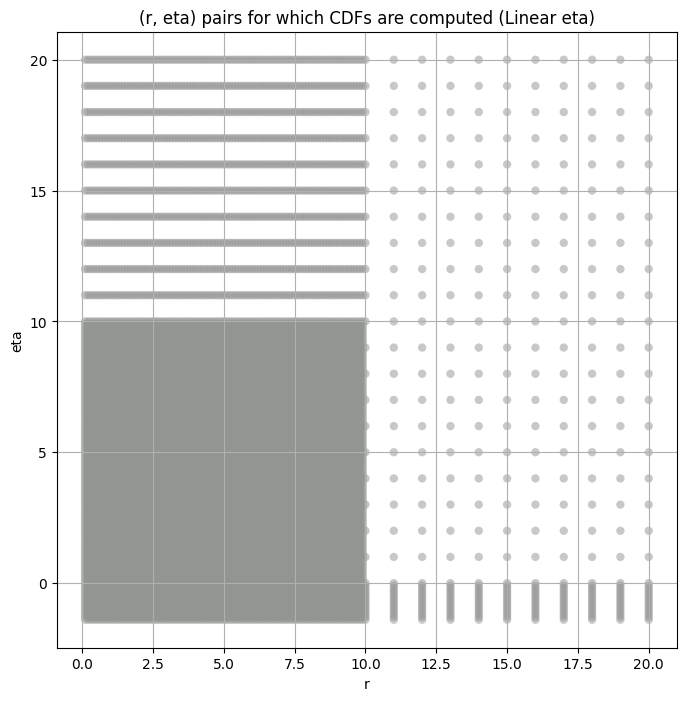

(r,eta),cdf    r  eta  \
0  ((0.1, -1.4), <scipy.interpolate._fitpack2.Int...  0.1 -1.4   
1  ((0.1, -1.3), <scipy.interpolate._fitpack2.Int...  0.1 -1.3   
2  ((0.1, -1.2), <scipy.interpolate._fitpack2.Int...  0.1 -1.2   
3  ((0.1, -1.1), <scipy.interpolate._fitpack2.Int...  0.1 -1.1   
4  ((0.1, -1.0), <scipy.interpolate._fitpack2.Int...  0.1 -1.0   

                                                 cdf      variance  \
0  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.628800e+06   
1  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.991680e+07   
2  <scipy.interpolate._fitpack2.InterpolatedUniva...  2.395008e+08   
3  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.037837e+09   
4  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.632429e+09   

        kurtosis  
0  554265.000000  
1   96192.272727  
2   29390.000000  
3   11997.692308  
4    5874.890110

In [7]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [8]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [9]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Layer 2


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 3


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 4


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 5


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 6


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 7


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 8


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 9


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

obs_var    var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                 
2      1620.265600  1466.841600  1779.921800   0.232590   -0.116969   
3       363.693020   343.105830   384.706970   1.157368    0.861863   
4        67.676250    63.825962    71.663124   2.984240    2.370700   
5        11.568170    10.808815    12.363514   4.878991    3.933630   
6         1.933758     1.777439     2.103910   8.847498    6.484944   
7         0.346441     0.311654     0.386359  15.220030   10.219967   
8         0.080651     0.070203     0.095151  32.158560   15.513039   
9         0.018841     0.015640     0.024107  68.141560   25.292933   

       kurt_upper  total_samples  
layer                             
2        0.627984         1604.0  
3        1.496571         6416.0  
4        3.709449        25664.0  
5        6.184278       102656.0  
6       14.128145       410624.0  
7       29.976894      1642496.0  
8      104.560486      6569984.0  
9      254.571980     26279936.0

## Initial Grid Search and Hypothesis Test Plots

In [10]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [11]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

obs_var  var_exclude_0  var_exclude_25  var_exclude_50  \
layer                                                               
2      1620.265600    1620.265625     1320.567749     1145.391968   
3       363.693020     363.693024      331.213562      309.844177   
4        67.676250      67.676247       64.321770       62.198826   
5        11.568170      11.568170       11.319335       11.144682   
6         1.933758       1.933758        1.868340        1.828795   
7         0.346441       0.346441        0.329734        0.320183   
8         0.080651       0.080651        0.074750        0.071848   
9         0.018841       0.018841        0.016818        0.015898   

       var_exclude_75  var_exclude_100  var_exclude_150  var_exclude_200  \
layer                                                                      
2         1008.286560       891.896362       705.144470       556.320923   
3          292.568359       277.501984       251.891434       230.950073   
4           60.488155        58.998272        56.389252        54.125267   
5           10.991625        10.855438        10.616765        10.406284   
6            1.795715         1.766452         1.715367         1.670916   
7            0.312391         0.305606         0.293938         0.283983   
8            0.069517         0.067530         0.064173         0.061355   
9            0.015179         0.014577         0.013585         0.012777   

       var_exclude_250  var_exclude_300  var_exclude_350  var_exclude_500  
layer                                                                      
2           438.836243       339.360382       254.285294        96.828331  
3           212.798767       196.849289       182.883804       147.997330  
4            52.107544        50.294155        48.636742        44.305477  
5            10.217244        10.041625         9.876711         9.431111  
6             1.631135         1.594817         1.561248         1.472294  
7             0.275194         0.267271         0.260027         0.241301  
8             0.058904         0.056725         0.054760         0.049782  
9             0.012090         0.011493         0.010963         0.009665

####
Layer  2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 0 0.02489895518877605 1620.2656


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 25 0.03347501518434215 1320.5677


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 50 0.05055409380508291 1145.392


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 75 0.06595518136055367 1008.28656


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 100 0.08074455181128459 891.89636


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 150 0.10854572856976208 705.1445


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 200 0.13506192297343778 556.3209


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 250 0.15900209593589876 438.83624


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 300 0.1816795059516233 339.36038


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 350 0.20721915656275014 254.2853


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 500 0.2906856017727961 96.82833
Number of samples: 1604, Without approximation : 1604.0


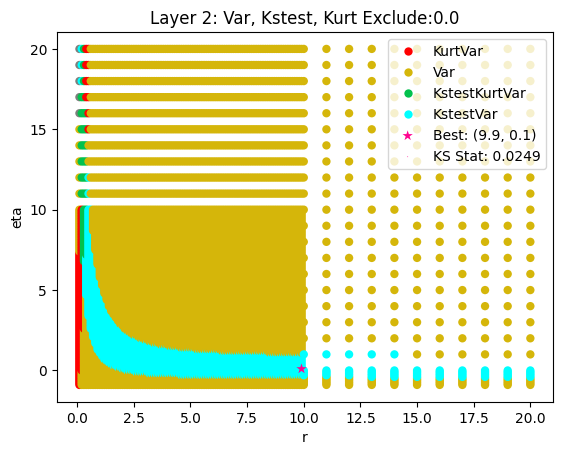

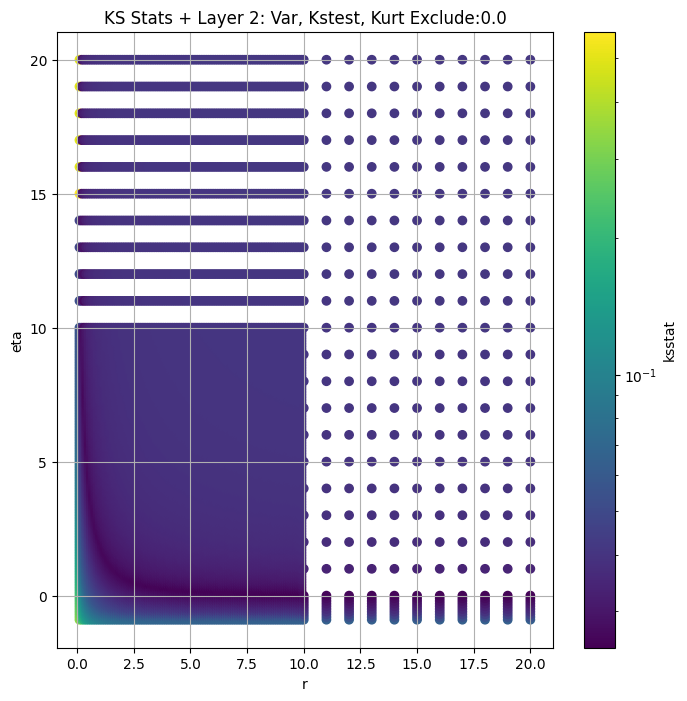

####
Layer  3


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 0 0.007488270253213469 363.69302


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 25 0.010004319202356005 331.21356


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 50 0.014963679324399126 309.84418


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 75 0.01943060247333772 292.56836


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 100 0.02365938902091147 277.50198


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 150 0.031652882835543794 251.89143


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 200 0.039105988020629145 230.95007


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 250 0.04693362518765576 212.79877


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 300 0.05412326118492994 196.84929


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 350 0.060989729822868655 182.8838


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 500 0.08014696136288235 147.99733
Number of samples: 6416, Without approximation : 6416.0


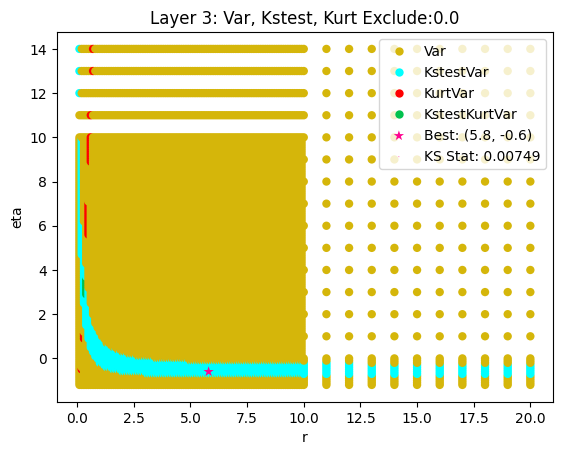

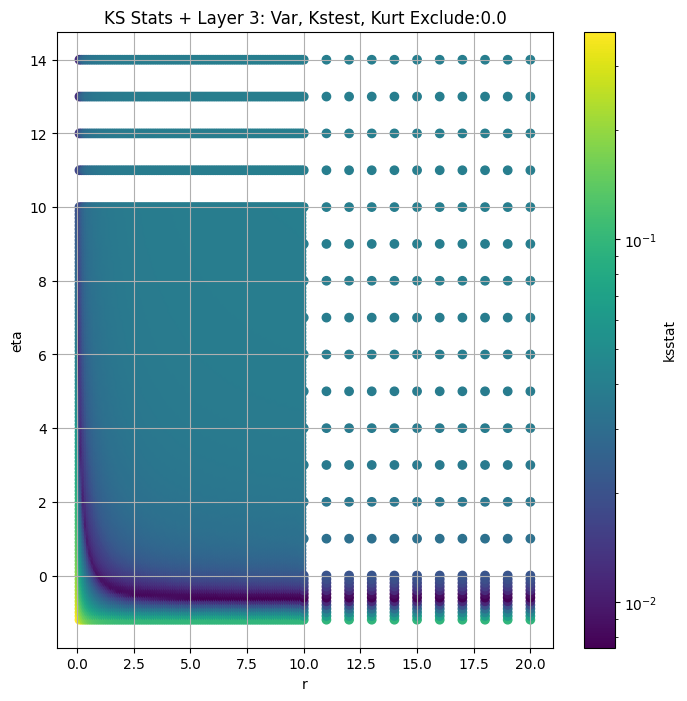

####
Layer  4


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 0 0.004839934824475756 67.67625


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 25 0.007231214517856521 64.32177


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 50 0.008086885234214858 62.198826


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 75 0.00869078692896108 60.488155


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 100 0.009245486097112954 58.998272


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 150 0.01178958672585162 56.38925


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 200 0.014720817014763021 54.125267


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 250 0.01691316154181821 52.107544


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 300 0.01942894610585888 50.294155


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 350 0.021721643693437098 48.63674


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 500 0.028320886998204675 44.305477
Number of samples: 25664, Without approximation : 25664.0


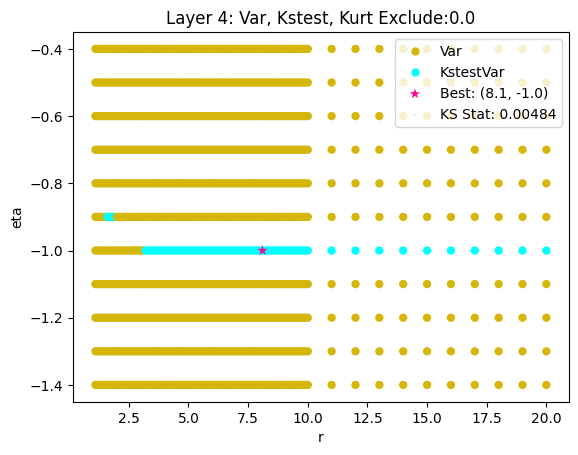

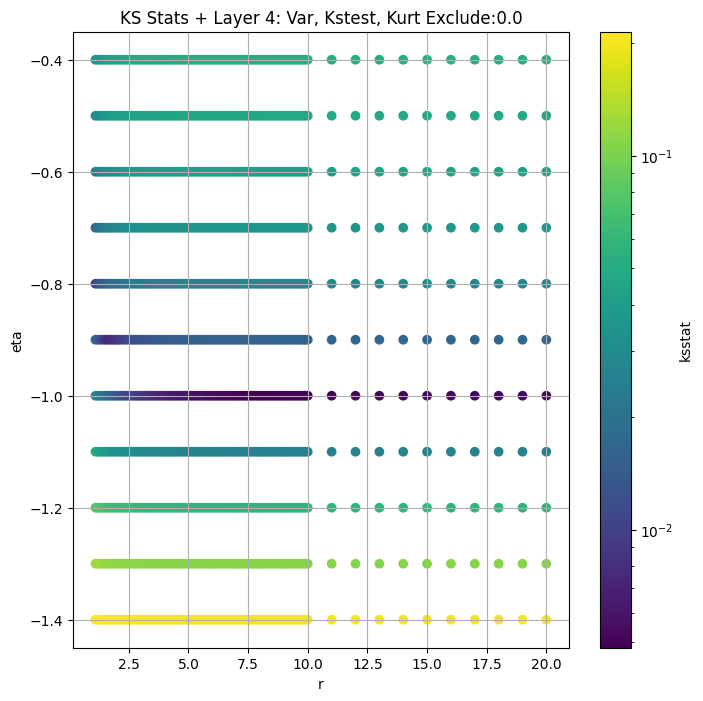

####
Layer  5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 0 0.005400916415786883 11.56817


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 25 0.005594166405397449 11.319335


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 50 0.005402293766459176 11.144682


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 75 0.005579166965273802 10.991625


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 100 0.005759993225754559 10.855438


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 150 0.006191292641813152 10.616765


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 200 0.006715383810186382 10.406284


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 250 0.007270671172119346 10.217244


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 300 0.007717842688718446 10.041625


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 350 0.00814498549190934 9.876711


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 500 0.009246901109802745 9.431111
Number of samples: 100000, Without approximation : 102656.0


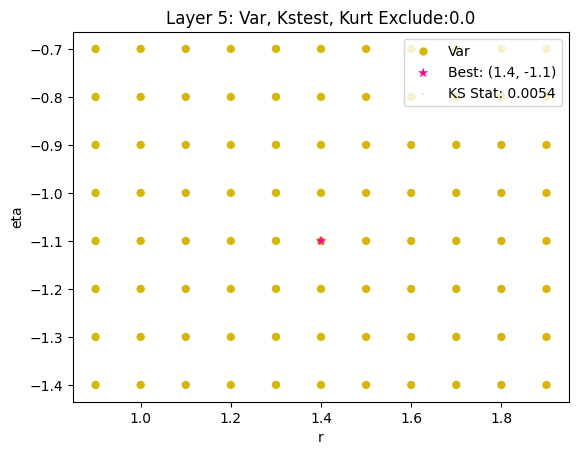

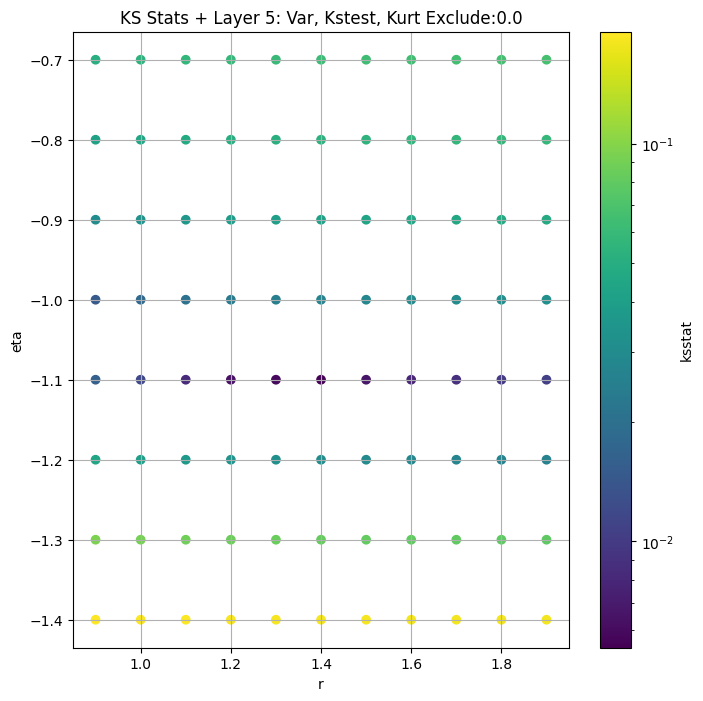

####
Layer  6


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 0 0.020037852545974483 1.9337575


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 25 0.01991716610514821 1.8683395


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 50 0.019721988424467707 1.8287951


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 75 0.019554334926082495 1.7957153


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 100 0.019402549330563845 1.7664523


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 150 0.01962002515683603 1.7153668


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 200 0.01966003920691628 1.6709164


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 250 0.02020674919540677 1.6311346


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 300 0.020721774209272237 1.5948166


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 350 0.02056062434142175 1.5612483


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 500 0.020032373887091004 1.4722941
Number of samples: 100000, Without approximation : 410624.0


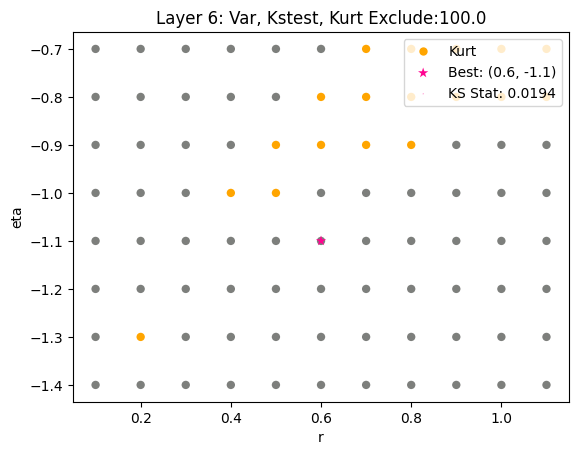

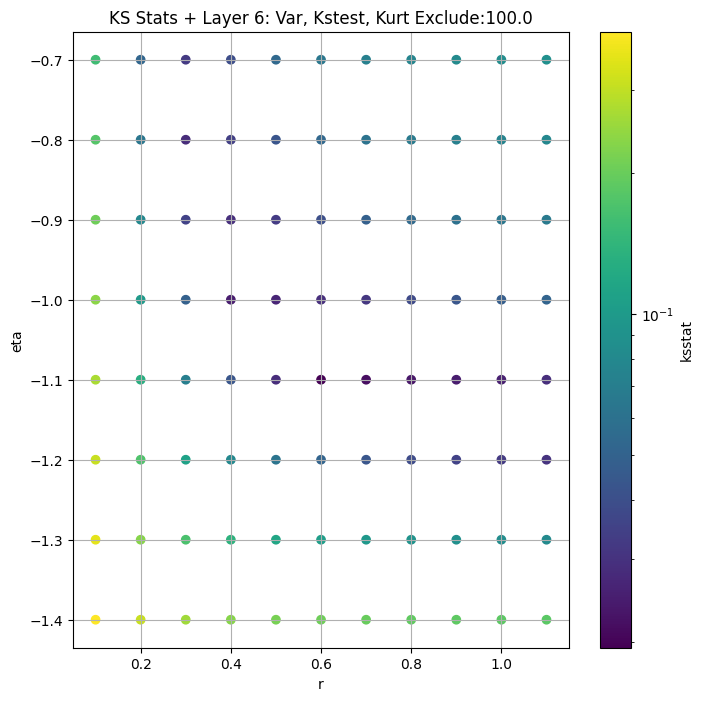

####
Layer  7


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 0 0.022026595724509712 0.34644133


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 25 0.02375644133566901 0.32973394


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 50 0.02479295137485249 0.32018277


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 75 0.025665292179331334 0.3123912


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 100 0.026445620516823087 0.30560642


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 150 0.027835501527335604 0.29393828


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 200 0.029072720264777918 0.28398252


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 250 0.030207186807171715 0.2751939


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 300 0.030218239174762462 0.26727065


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 350 0.029686423974264242 0.26002708


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 500 0.03221556983116802 0.2413006
Number of samples: 100000, Without approximation : 1642496.0


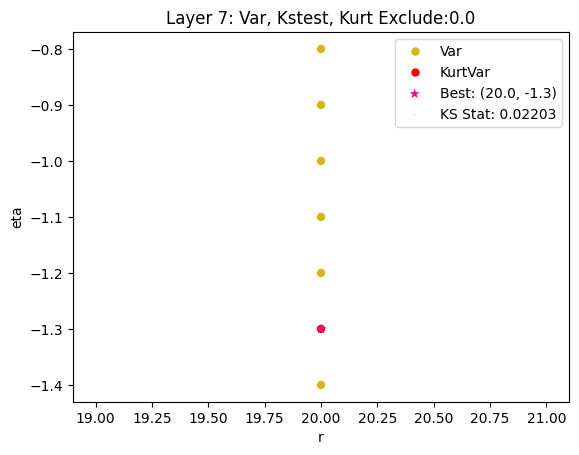

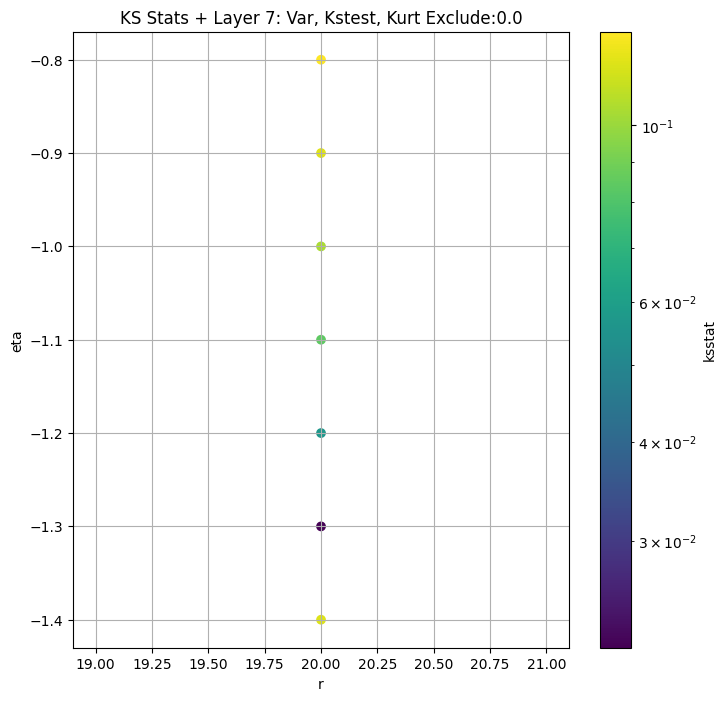

####
Layer  8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 0 0.015002432576644631 0.08065148


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 25 0.014072648219820405 0.0747504


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 50 0.012932193323911212 0.07184827


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 75 0.011989924551216058 0.06951725


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 100 0.011173590752554474 0.06752997


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 150 0.009729784793034213 0.064173445


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 200 0.008458982751473665 0.06135535


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 250 0.00912168160853355 0.05890357


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 300 0.011240164028039734 0.056725144


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 350 0.012301556428860994 0.05475976


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 500 0.012119391424548986 0.049781673
Number of samples: 100000, Without approximation : 6569984.0


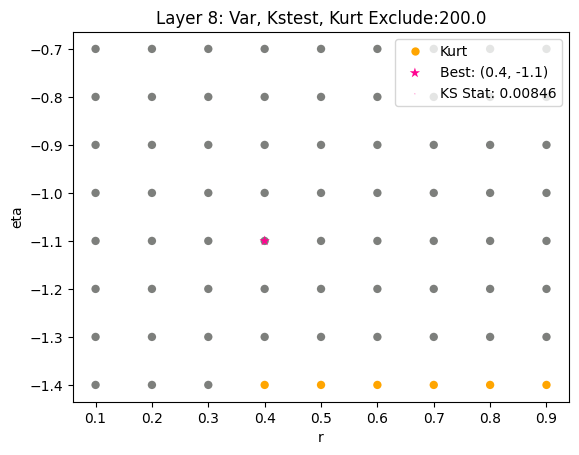

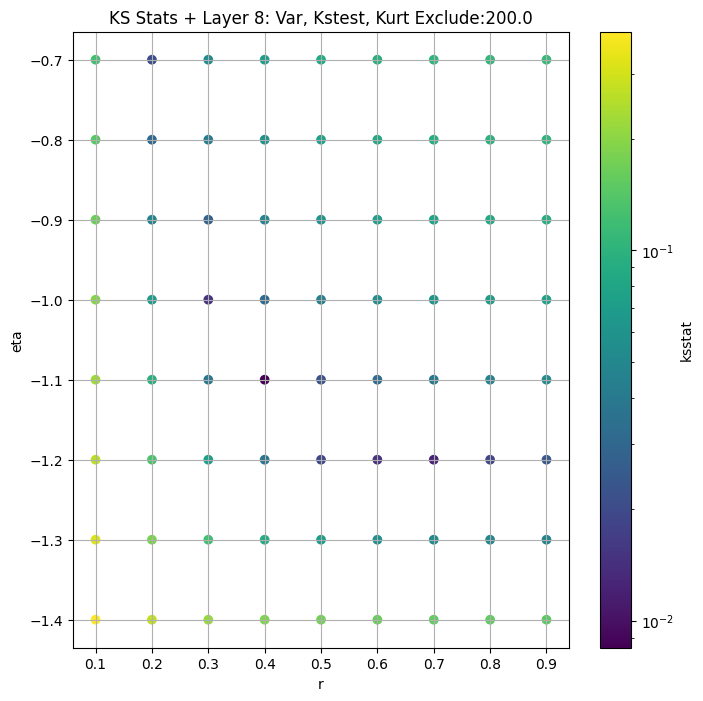

####
Layer  9


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 0 0.017694666458168307 0.018840509


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 25 0.014298681071890917 0.016818434


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 50 0.015297842416925556 0.015897568


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 75 0.016677445653511258 0.0151794


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 100 0.017913256352097617 0.014576739


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 150 0.016886934684819832 0.013585145


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 200 0.018331458199357997 0.012776824


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 250 0.017667628855993045 0.012090445


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 300 0.018819161784365934 0.011492502


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 350 0.01993733875039394 0.010963165


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 500 0.02214119516198143 0.009664877
Number of samples: 100000, Without approximation : 26279936.0


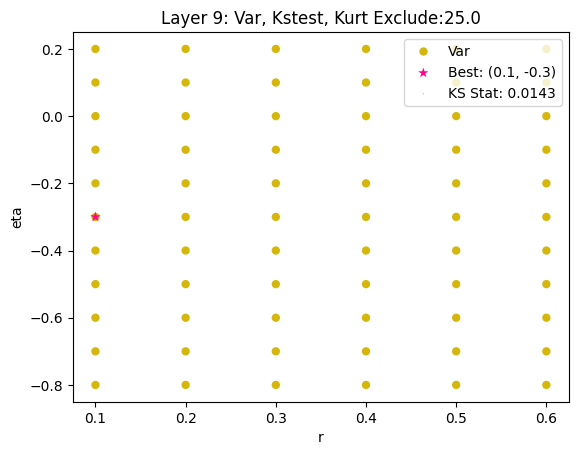

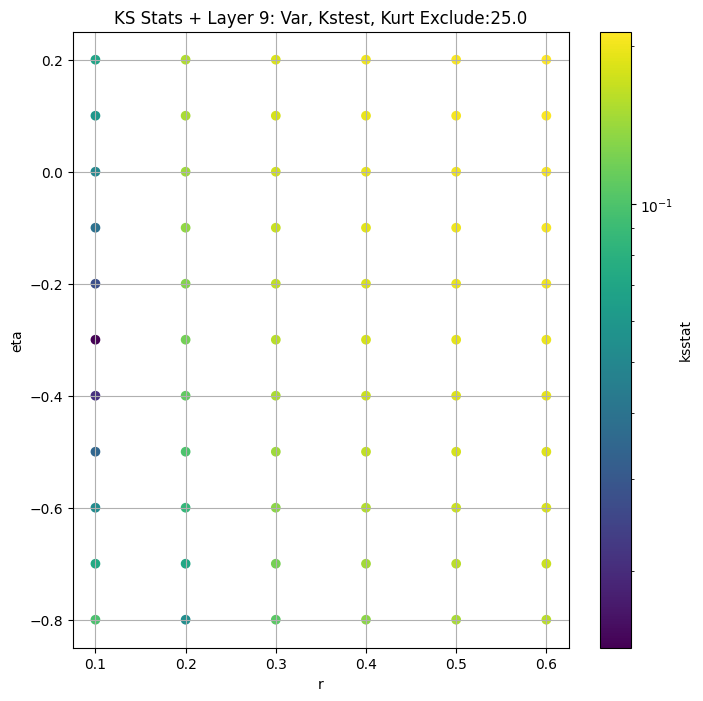

obs_var    var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                 
2      1620.265600  1466.841600  1779.921800   0.232590   -0.116969   
3       363.693020   343.105830   384.706970   1.157368    0.861863   
4        67.676250    63.825962    71.663124   2.984240    2.370700   
5        11.568170    10.808815    12.363514   4.878991    3.933630   
6         1.933758     1.777439     2.103910   8.847498    6.484944   
7         0.346441     0.311654     0.386359  15.220030   10.219967   
8         0.080651     0.070203     0.095151  32.158560   15.513039   
9         0.018841     0.015640     0.024107  68.141560   25.292933   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        0.627984         1604.0             0.024899        9.9          0.1   
3        1.496571         6416.0             0.007488        5.8         -0.6   
4        3.709449        25664.0             0.004840        8.1         -1.0   
5        6.184278       102656.0             0.005401        1.4         -1.1   
6       14.128145       410624.0             0.019403        0.6         -1.1   
7       29.976894      1642496.0             0.022027       20.0         -1.3   
8      104.560486      6569984.0             0.008459        0.4         -1.1   
9      254.571980     26279936.0             0.014299        0.1         -0.3   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2       2.706929e+03                     0.0         1620.265600   
3       8.001653e+02                     0.0          363.693020   
4       2.130896e+02                     0.0           67.676250   
5       3.642950e+01                     0.0           11.568170   
6       2.008992e+00                   100.0            1.766452   
7       2.133540e+00                     0.0            0.346441   
8       1.846189e-02                   200.0            0.061355   
9       1.314006e-14                    25.0            0.016818   

       kstest_stat_cutoff_0.05  
layer                           
2                     0.033804  
3                     0.016929  
4                     0.008471  
5                     0.004237  
6                     0.002119  
7                     0.001060  
8                     0.000530  
9                     0.000265

In [12]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        if len(sample) == 0:
            continue
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [13]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Layer 2


  0%|          | 0/49 [00:00<?, ?it/s]

Finding Minimum after computing 49 CDFs
layer 2, 0.0 + 100 = 100, ksstat: 0.08806963851914162, var: 891.8963623046875


  0%|          | 0/49 [00:00<?, ?it/s]

Finding Minimum after computing 49 CDFs
layer 2, 0.0 + 75 = 75, ksstat: 0.07433694288372295, var: 1008.2865600585938


  0%|          | 0/49 [00:00<?, ?it/s]

Finding Minimum after computing 49 CDFs
layer 2, 0.0 + 50 = 50, ksstat: 0.05992367012932365, var: 1145.3919677734375


  0%|          | 0/49 [00:00<?, ?it/s]

Finding Minimum after computing 49 CDFs
layer 2, 0.0 + 25 = 25, ksstat: 0.04379427906978539, var: 1320.5677490234375


  0%|          | 0/49 [00:00<?, ?it/s]

Finding Minimum after computing 49 CDFs
layer 2, 0.0 + 0 = 0, ksstat: 0.02489895518877605, var: 1620.265625
Number of samples: 1604, Without approximation : 1604.0


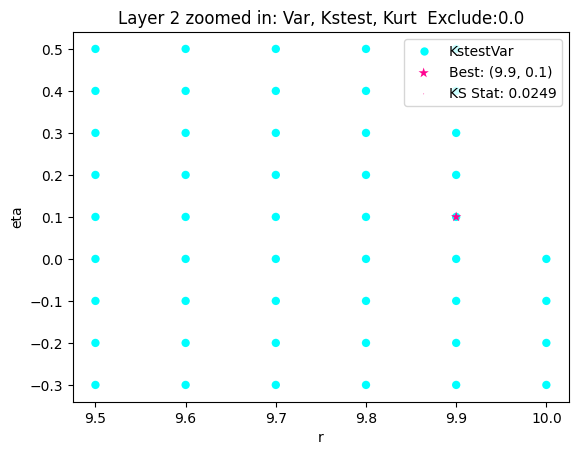

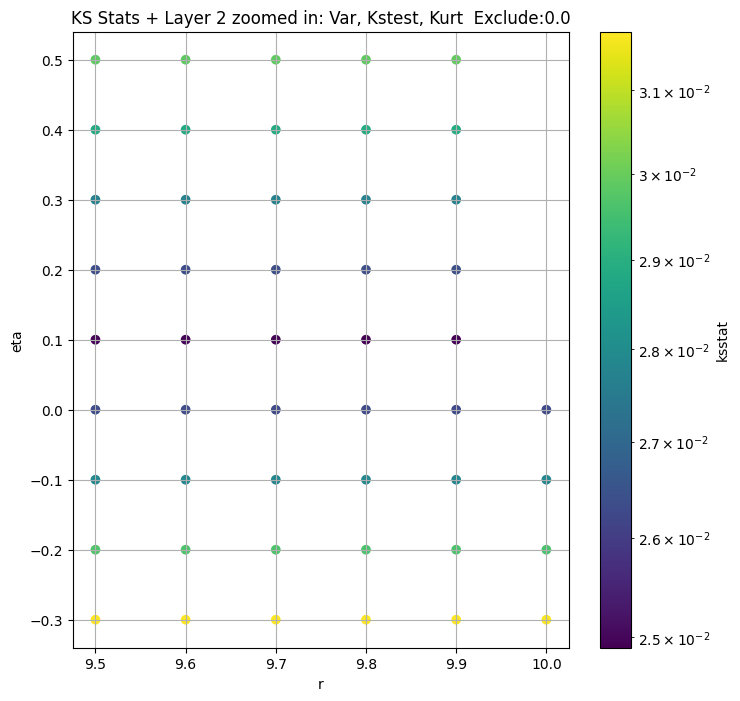

Layer 3


  0%|          | 0/171 [00:00<?, ?it/s]

Finding Minimum after computing 171 CDFs
layer 3, 0.0 + 100 = 100, ksstat: 0.024594545344824192, var: 277.5019836425781


  0%|          | 0/171 [00:00<?, ?it/s]

Finding Minimum after computing 171 CDFs
layer 3, 0.0 + 75 = 75, ksstat: 0.019735520990710742, var: 292.568359375


  0%|          | 0/171 [00:00<?, ?it/s]

Finding Minimum after computing 171 CDFs
layer 3, 0.0 + 50 = 50, ksstat: 0.015325967829479592, var: 309.84417724609375


  0%|          | 0/171 [00:00<?, ?it/s]

Finding Minimum after computing 171 CDFs
layer 3, 0.0 + 25 = 25, ksstat: 0.010374623916296177, var: 331.21356201171875


  0%|          | 0/171 [00:00<?, ?it/s]

Finding Minimum after computing 171 CDFs
layer 3, 0.0 + 0 = 0, ksstat: 0.007488270253213469, var: 363.6930236816406
Number of samples: 6416, Without approximation : 6416.0


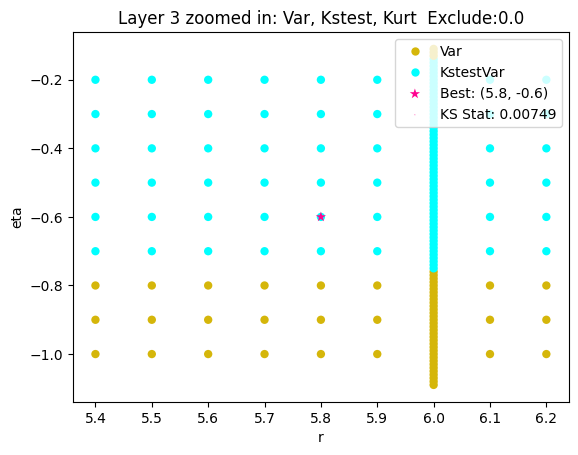

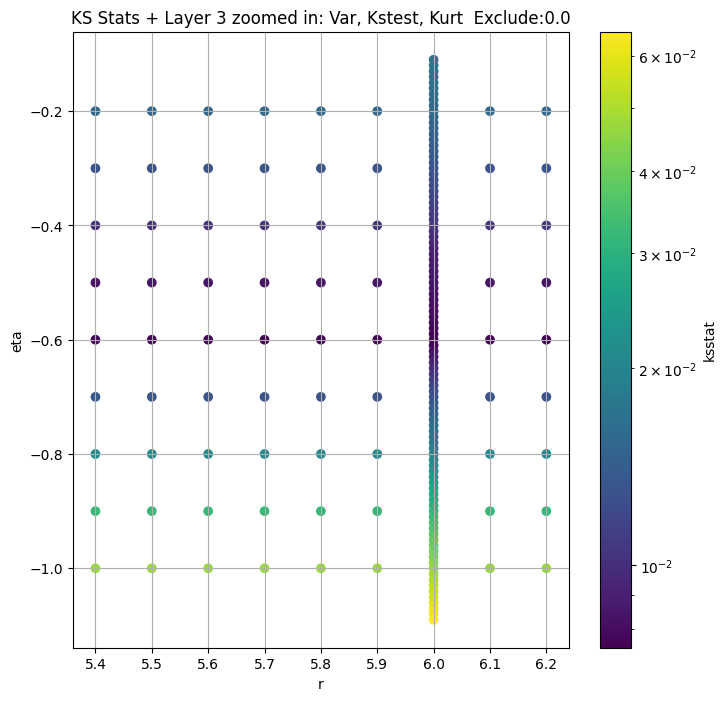

Layer 4


  0%|          | 0/167 [00:00<?, ?it/s]

Finding Minimum after computing 167 CDFs
layer 4, 0.0 + 100 = 100, ksstat: 0.00902368293975997, var: 58.99827194213867


  0%|          | 0/167 [00:00<?, ?it/s]

Finding Minimum after computing 167 CDFs
layer 4, 0.0 + 75 = 75, ksstat: 0.007467153417464956, var: 60.488155364990234


  0%|          | 0/167 [00:00<?, ?it/s]

Finding Minimum after computing 167 CDFs
layer 4, 0.0 + 50 = 50, ksstat: 0.005746016185054548, var: 62.19882583618164


  0%|          | 0/167 [00:00<?, ?it/s]

Finding Minimum after computing 167 CDFs
layer 4, 0.0 + 25 = 25, ksstat: 0.004467610239017428, var: 64.32176971435547


  0%|          | 0/167 [00:00<?, ?it/s]

Finding Minimum after computing 167 CDFs
layer 4, 0.0 + 0 = 0, ksstat: 0.004839934824475756, var: 67.6762466430664
Number of samples: 25664, Without approximation : 25664.0


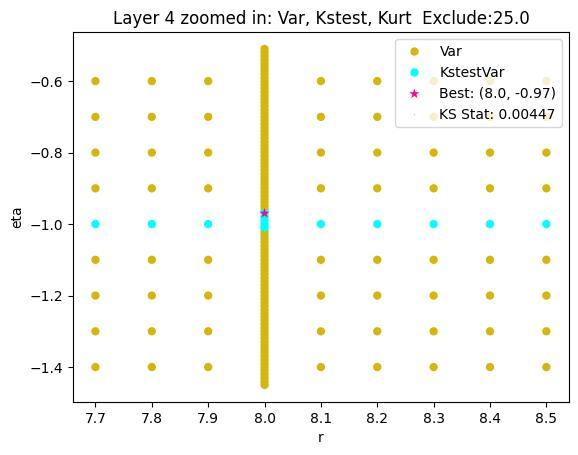

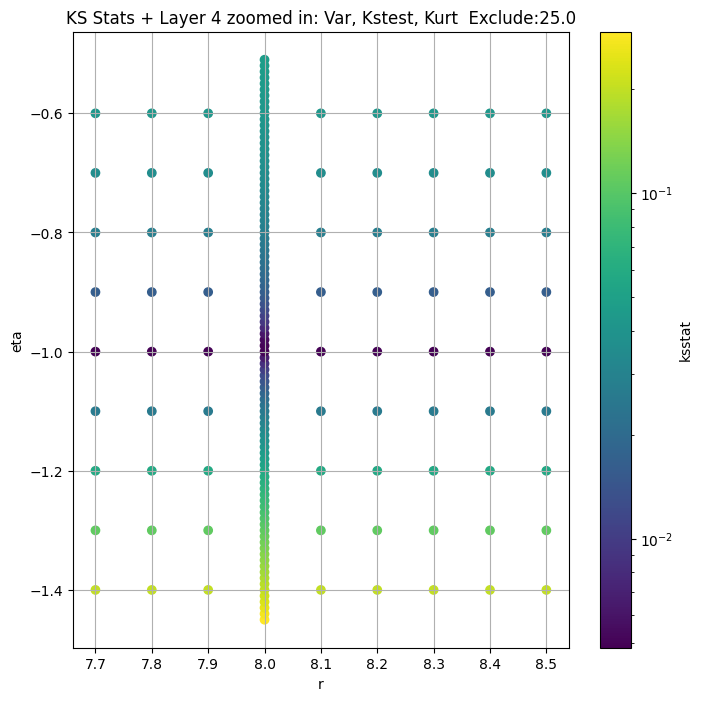

Layer 5


  0%|          | 0/1570 [00:00<?, ?it/s]

Finding Minimum after computing 1570 CDFs
layer 5, 0.0 + 100 = 100, ksstat: 0.005609900982679938, var: 10.855438232421875


  0%|          | 0/1570 [00:00<?, ?it/s]

Finding Minimum after computing 1570 CDFs
layer 5, 0.0 + 75 = 75, ksstat: 0.005352432111152217, var: 10.99162483215332


  0%|          | 0/1570 [00:00<?, ?it/s]

Finding Minimum after computing 1570 CDFs
layer 5, 0.0 + 50 = 50, ksstat: 0.00537085393410186, var: 11.144681930541992


  0%|          | 0/1570 [00:00<?, ?it/s]

Finding Minimum after computing 1570 CDFs
layer 5, 0.0 + 25 = 25, ksstat: 0.005338242470583898, var: 11.319334983825684


  0%|          | 0/1570 [00:00<?, ?it/s]

Finding Minimum after computing 1570 CDFs
layer 5, 0.0 + 0 = 0, ksstat: 0.0053811678245669625, var: 11.568169593811035
Number of samples: 100000, Without approximation : 102656.0


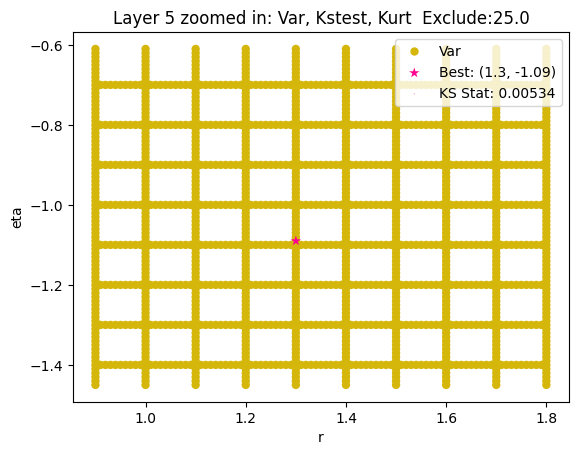

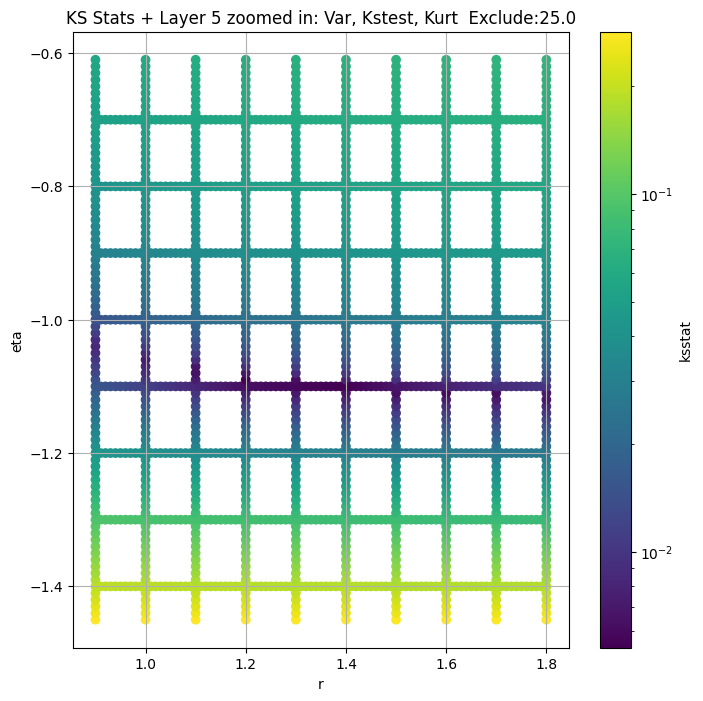

Layer 6


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
layer 6, 100.0 + 100 = 200, ksstat: 0.01781370158979495, var: 1.6709164381027222


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
layer 6, 100.0 + 75 = 175, ksstat: 0.01792940771697349, var: 1.6924382448196411


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
layer 6, 100.0 + 50 = 150, ksstat: 0.018050571101666357, var: 1.7153668403625488


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
layer 6, 100.0 + 25 = 125, ksstat: 0.01817767758827643, var: 1.739861011505127


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
layer 6, 100.0 + 0 = 100, ksstat: 0.018313026208346572, var: 1.7664523124694824


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
layer 6, 100.0 + -25 = 75, ksstat: 0.018257440133893188, var: 1.79571533203125


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
layer 6, 100.0 + -50 = 50, ksstat: 0.01780417227810238, var: 1.828795075416565


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
layer 6, 100.0 + -75 = 25, ksstat: 0.017699466066648628, var: 1.8683395385742188


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
layer 6, 100.0 + -100 = 0, ksstat: 0.01744288330251481, var: 1.9337575435638428
Number of samples: 100000, Without approximation : 410624.0


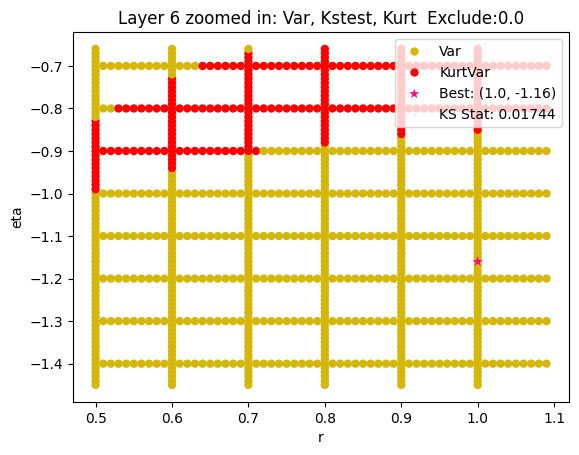

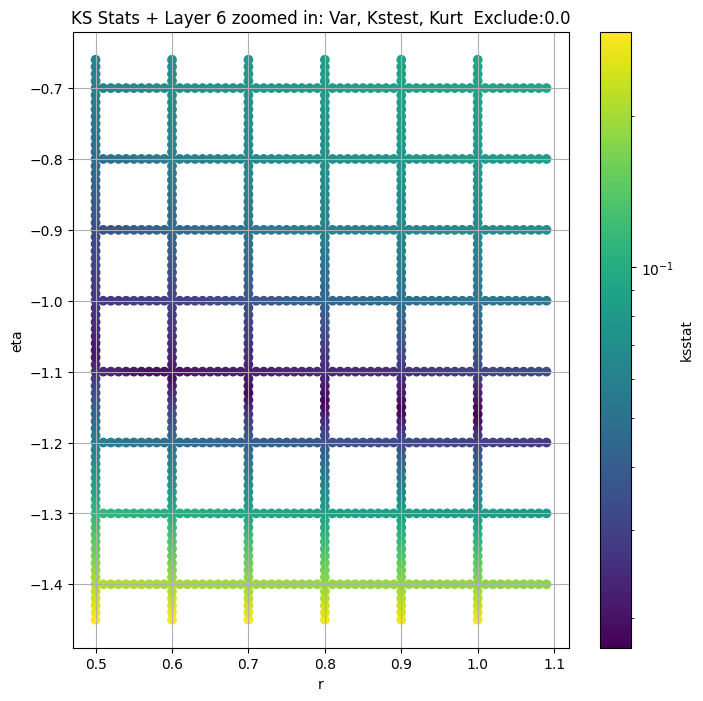

Layer 7


  0%|          | 0/6 [00:00<?, ?it/s]

Finding Minimum after computing 6 CDFs
layer 7, 0.0 + 100 = 100, ksstat: 0.026445620516823087, var: 0.3056064248085022


  0%|          | 0/6 [00:00<?, ?it/s]

Finding Minimum after computing 6 CDFs
layer 7, 0.0 + 75 = 75, ksstat: 0.025665292179331334, var: 0.3123911917209625


  0%|          | 0/6 [00:00<?, ?it/s]

Finding Minimum after computing 6 CDFs
layer 7, 0.0 + 50 = 50, ksstat: 0.02479295137485249, var: 0.32018277049064636


  0%|          | 0/6 [00:00<?, ?it/s]

Finding Minimum after computing 6 CDFs
layer 7, 0.0 + 25 = 25, ksstat: 0.02375644133566901, var: 0.3297339379787445


  0%|          | 0/6 [00:00<?, ?it/s]

Finding Minimum after computing 6 CDFs
layer 7, 0.0 + 0 = 0, ksstat: 0.022026595724509712, var: 0.3464413285255432
Number of samples: 100000, Without approximation : 1642496.0


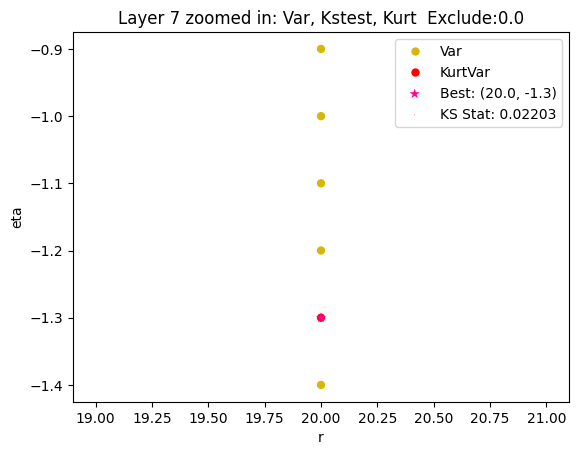

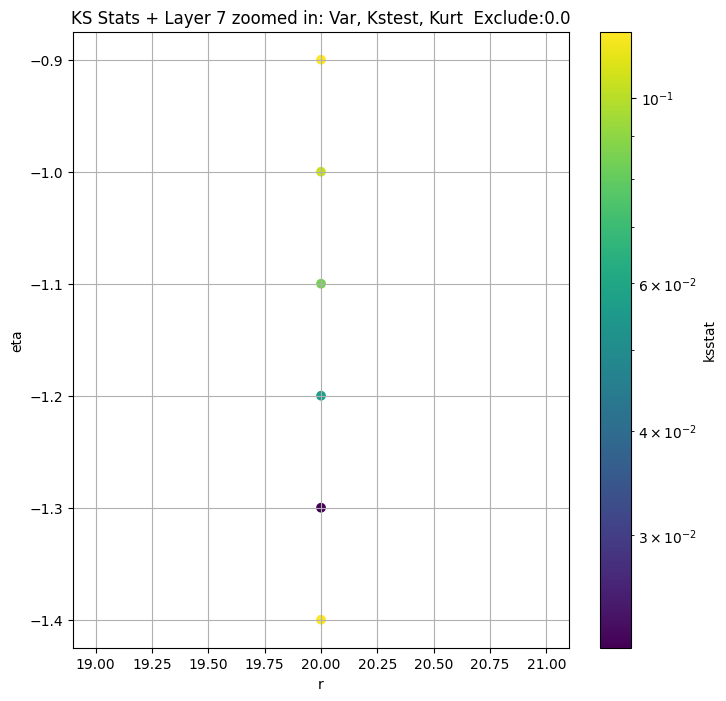

Layer 8


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
layer 8, 200.0 + 100 = 300, ksstat: 0.009028140308143362, var: 0.056725144386291504


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
layer 8, 200.0 + 75 = 275, ksstat: 0.008954966375243748, var: 0.05778462067246437


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
layer 8, 200.0 + 50 = 250, ksstat: 0.008873953787298272, var: 0.05890357121825218


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
layer 8, 200.0 + 25 = 225, ksstat: 0.008220561469801886, var: 0.06009003892540932


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
layer 8, 200.0 + 0 = 200, ksstat: 0.008458982751473665, var: 0.0613553486764431


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
layer 8, 200.0 + -25 = 175, ksstat: 0.008158156016041196, var: 0.06271126121282578


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
layer 8, 200.0 + -50 = 150, ksstat: 0.00709400043598285, var: 0.06417344510555267


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
layer 8, 200.0 + -75 = 125, ksstat: 0.007668889598101136, var: 0.06576777249574661


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
layer 8, 200.0 + -100 = 100, ksstat: 0.007477350381028314, var: 0.06752996891736984
Number of samples: 100000, Without approximation : 6569984.0


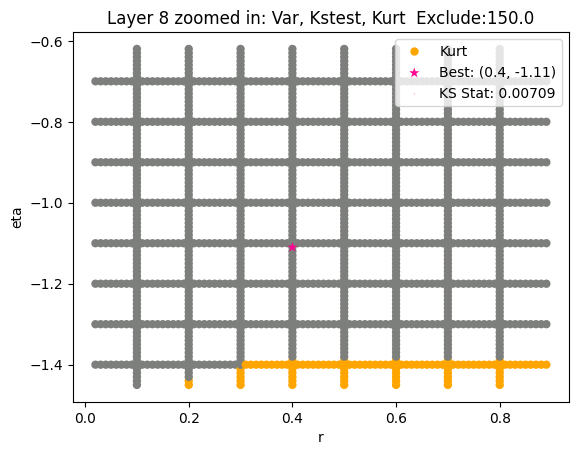

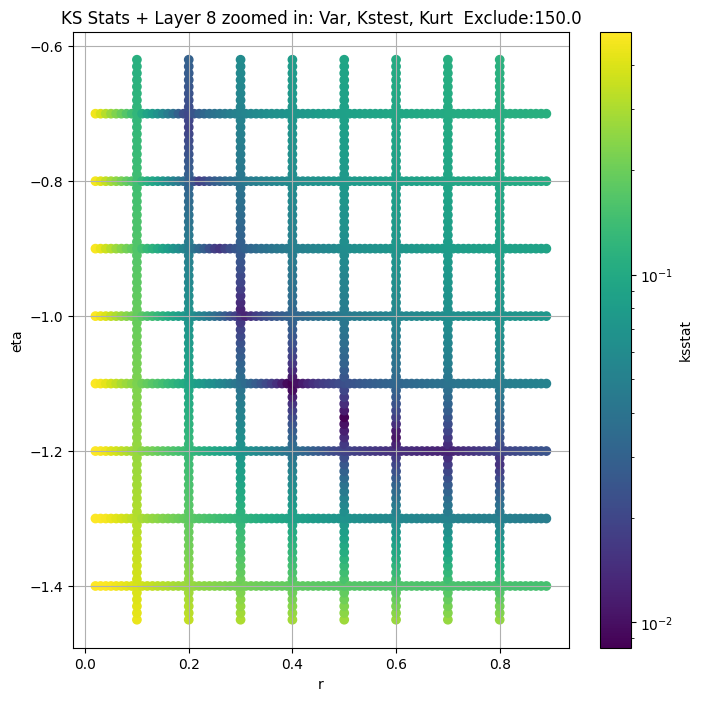

Layer 9


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
layer 9, 25.0 + 100 = 125, ksstat: 0.016000338332896602, var: 0.014052181504666805


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
layer 9, 25.0 + 75 = 100, ksstat: 0.015333459911678005, var: 0.014576738700270653


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
layer 9, 25.0 + 50 = 75, ksstat: 0.014142218755231695, var: 0.015179400332272053


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
layer 9, 25.0 + 25 = 50, ksstat: 0.014646698628296928, var: 0.015897568315267563


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
layer 9, 25.0 + 0 = 25, ksstat: 0.01397229665223998, var: 0.01681843400001526


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
layer 9, 25.0 + -25 = 0, ksstat: 0.013422154074348658, var: 0.01884050853550434
Number of samples: 100000, Without approximation : 26279936.0


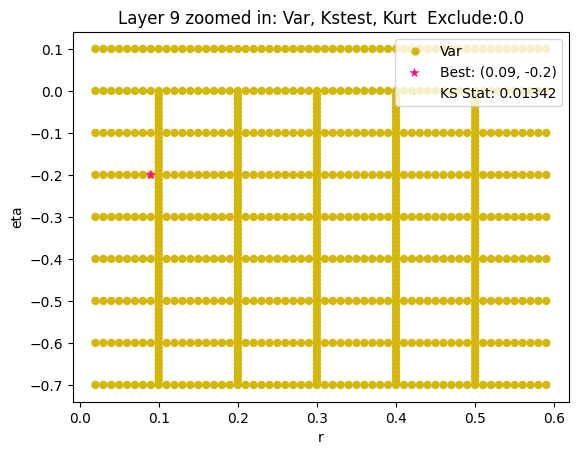

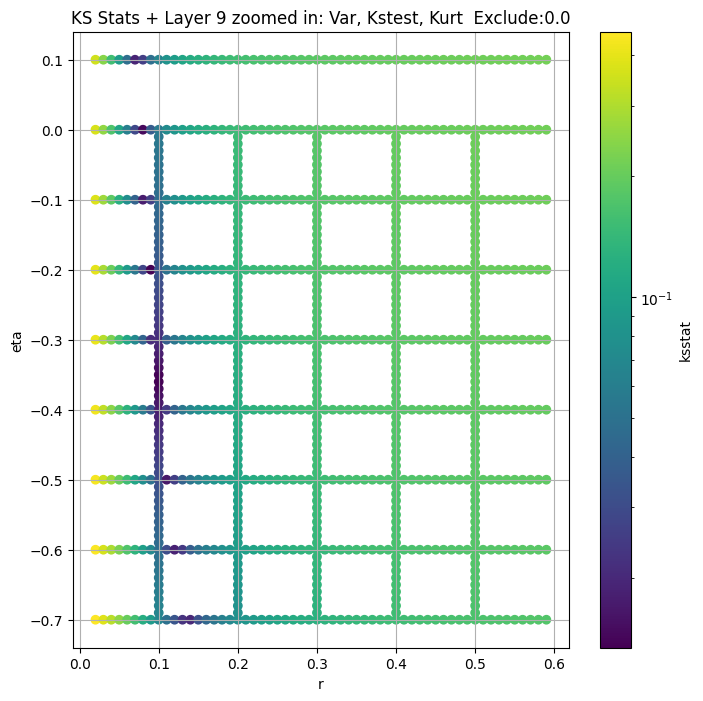

obs_var    var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                 
2      1620.265600  1466.841600  1779.921800   0.232590   -0.116969   
3       363.693020   343.105830   384.706970   1.157368    0.861863   
4        67.676250    63.825962    71.663124   2.984240    2.370700   
5        11.568170    10.808815    12.363514   4.878991    3.933630   
6         1.933758     1.777439     2.103910   8.847498    6.484944   
7         0.346441     0.311654     0.386359  15.220030   10.219967   
8         0.080651     0.070203     0.095151  32.158560   15.513039   
9         0.018841     0.015640     0.024107  68.141560   25.292933   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        0.627984         1604.0             0.024899        9.9          0.1   
3        1.496571         6416.0             0.007488        5.8         -0.6   
4        3.709449        25664.0             0.004840        8.1         -1.0   
5        6.184278       102656.0             0.005401        1.4         -1.1   
6       14.128145       410624.0             0.019403        0.6         -1.1   
7       29.976894      1642496.0             0.022027       20.0         -1.3   
8      104.560486      6569984.0             0.008459        0.4         -1.1   
9      254.571980     26279936.0             0.014299        0.1         -0.3   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2       2.706929e+03                     0.0         1620.265600   
3       8.001653e+02                     0.0          363.693020   
4       2.130896e+02                     0.0           64.321770   
5       3.642950e+01                     0.0           11.319335   
6       2.008992e+00                   100.0            1.933758   
7       2.133540e+00                     0.0            0.346441   
8       1.846189e-02                   200.0            0.064173   
9       1.314006e-14                    25.0            0.018841   

       kstest_stat_cutoff_0.05  kstest_stat_best  best_r  best_eta  \
layer                                                                
2                     0.033804          0.024899    9.90      0.10   
3                     0.016929          0.007488    5.80     -0.60   
4                     0.008471          0.004468    8.00     -0.97   
5                     0.004237          0.005338    1.30     -1.09   
6                     0.002119          0.017443    1.00     -1.16   
7                     0.001060          0.022027   20.00     -1.30   
8                     0.000530          0.007094    0.40     -1.11   
9                     0.000265          0.013422    0.09     -0.20   

         best_scale  best_exclude_cutoff  n_pval_0.05  
layer                                                  
2      2.706929e+03                  0.0         3043  
3      8.001653e+02                  0.0        32481  
4      1.948243e+02                 25.0        97443  
5      3.354919e+01                 25.0        64962  
6      5.687522e+00                  0.0         6088  
7      2.133540e+00                  0.0         3609  
8      2.014673e-02                150.0        38496  
9      1.017966e-16                  0.0        10827

In [14]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            if len(sample) == 0:
                continue
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

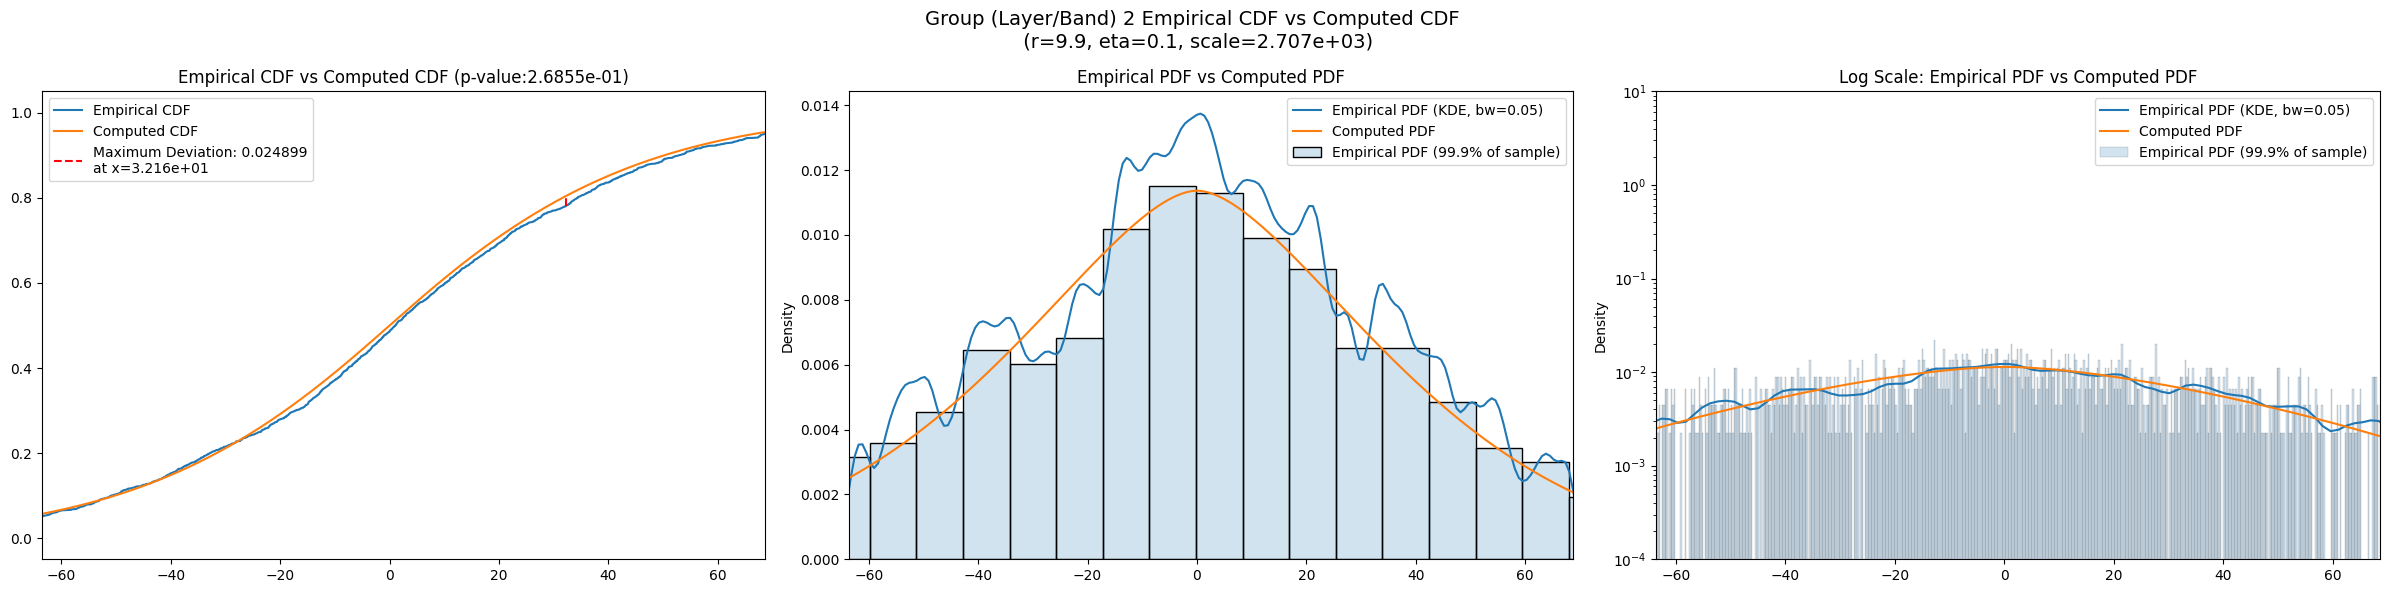

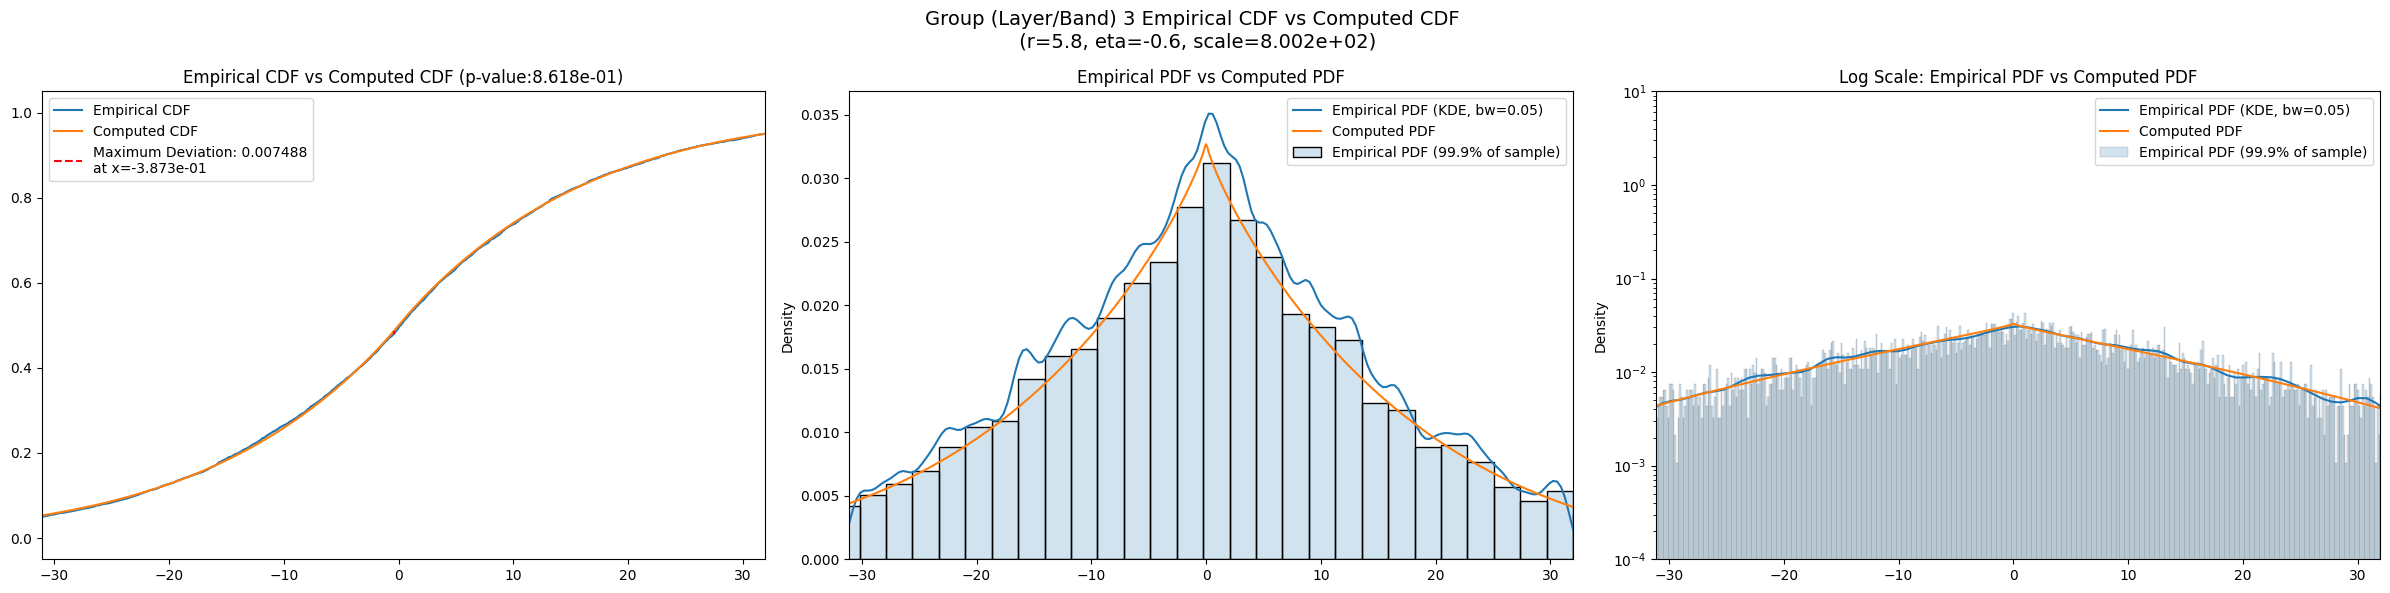

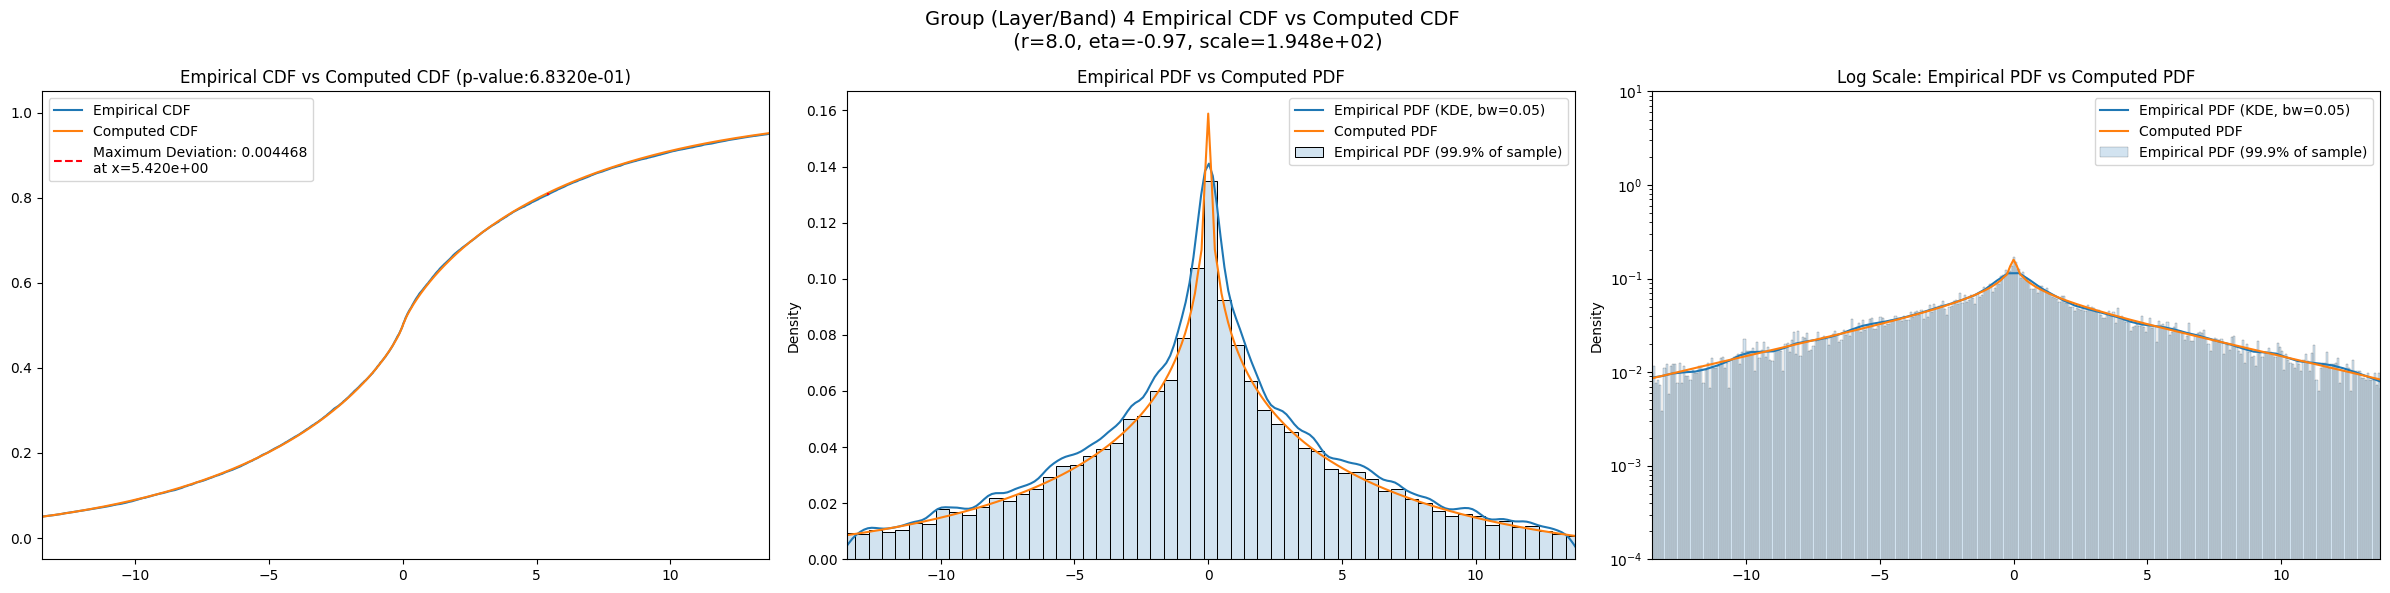

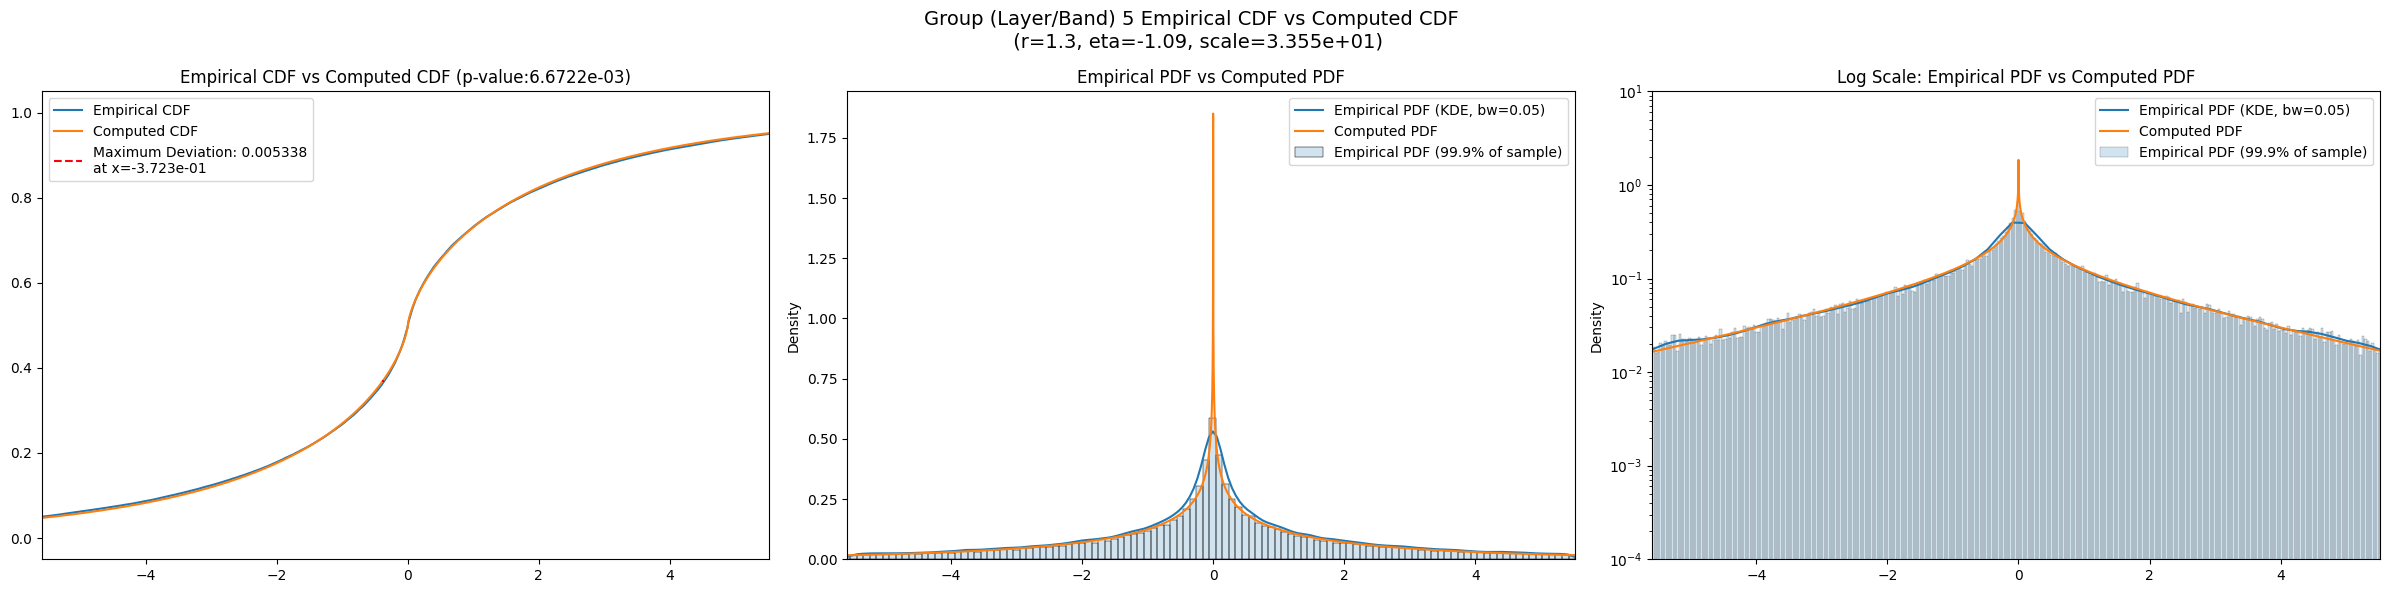

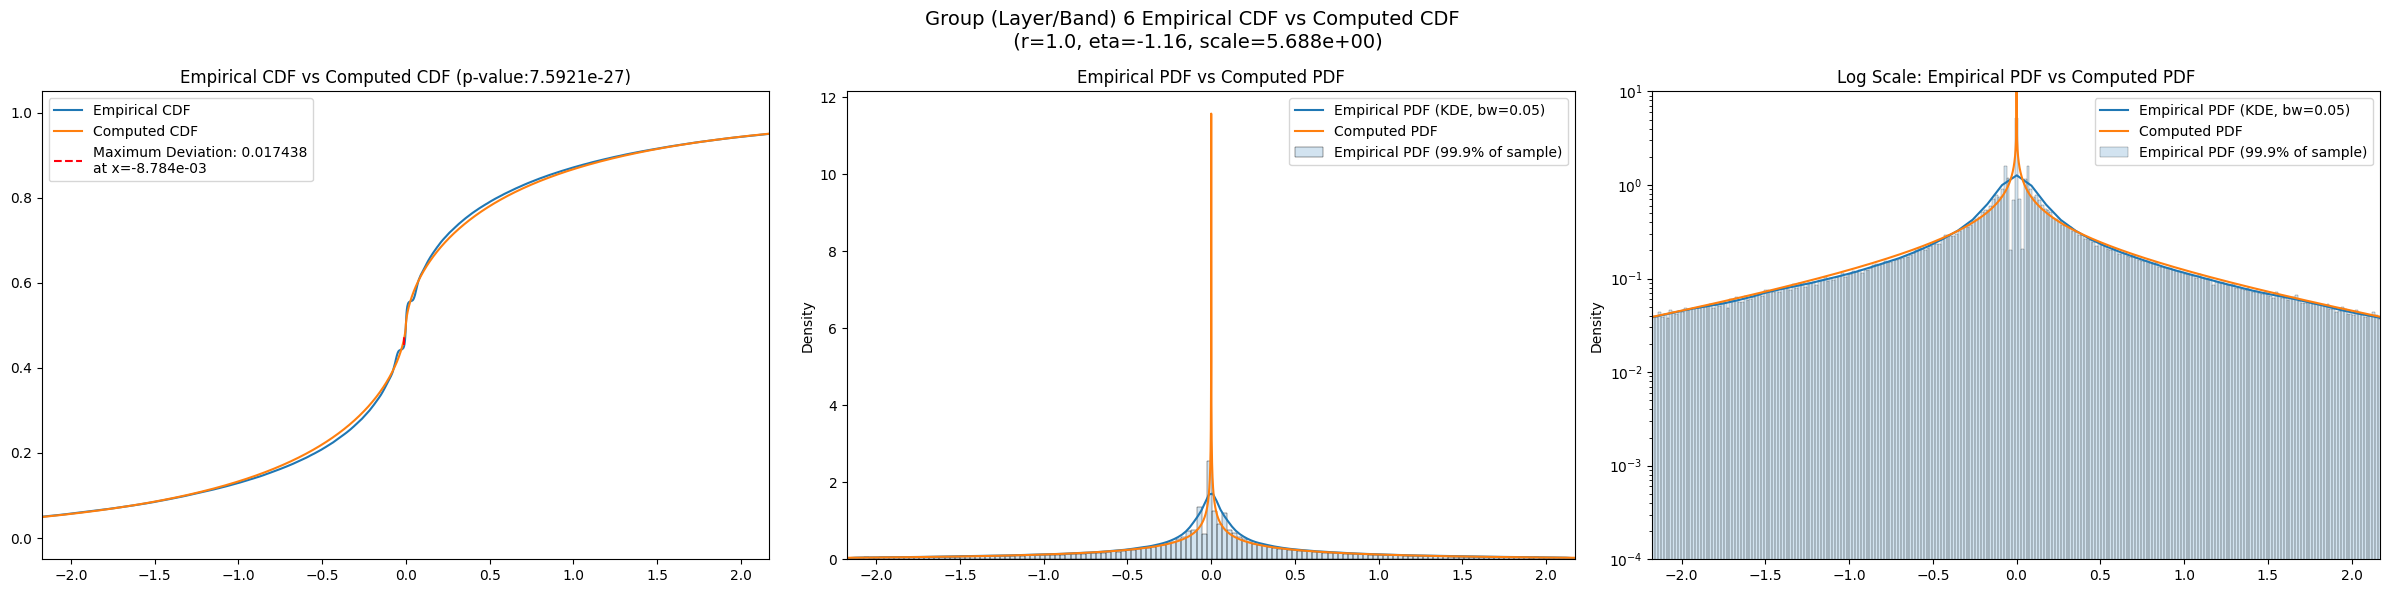

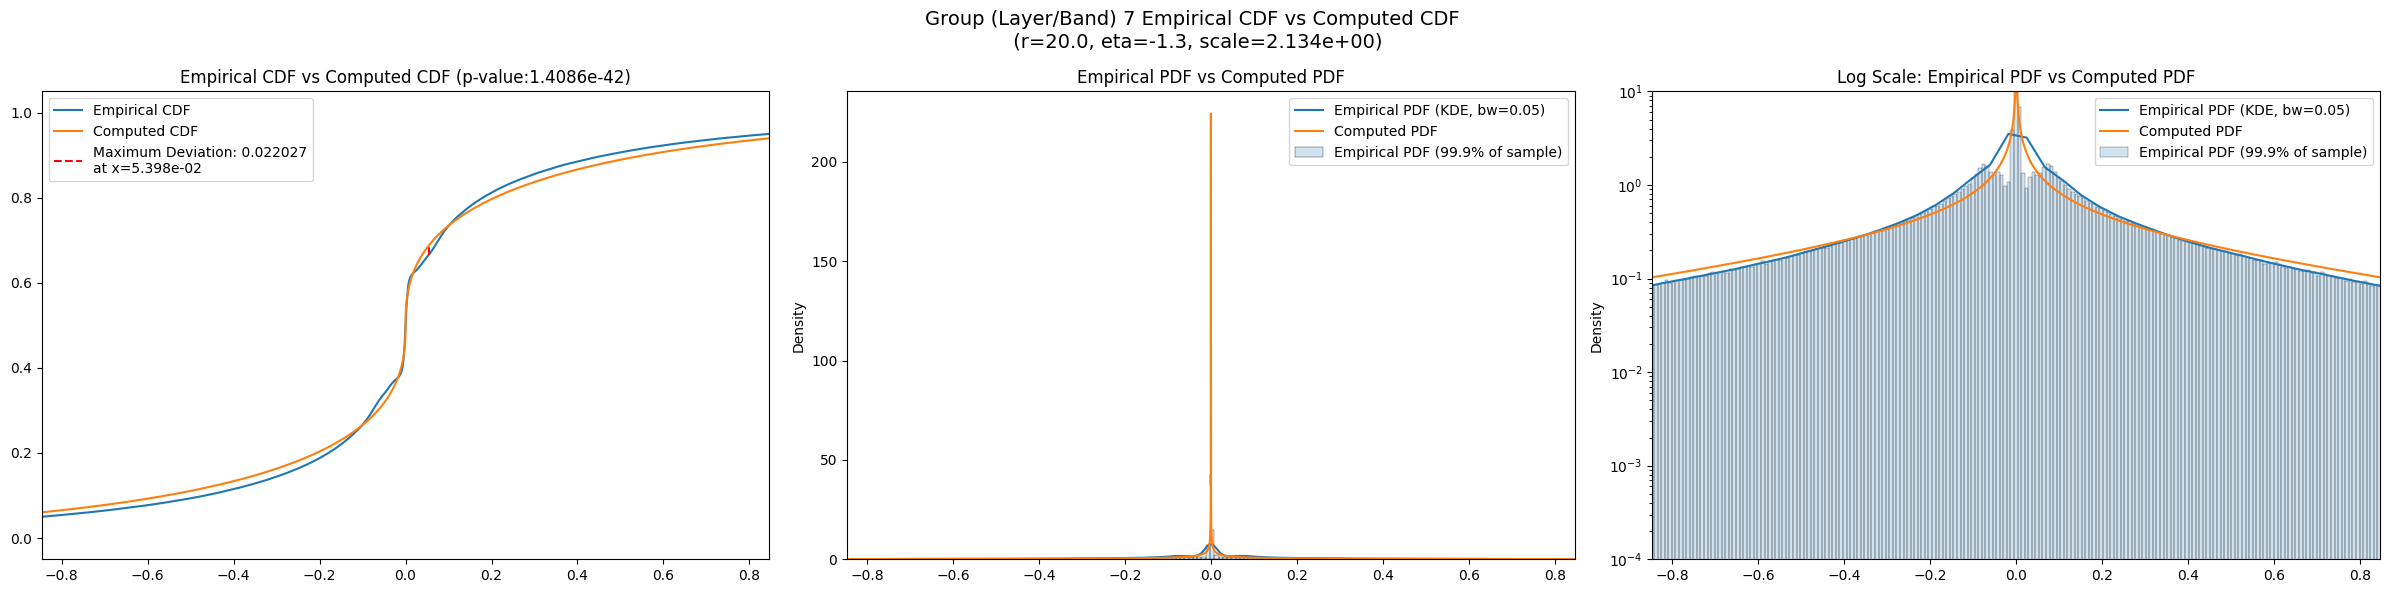

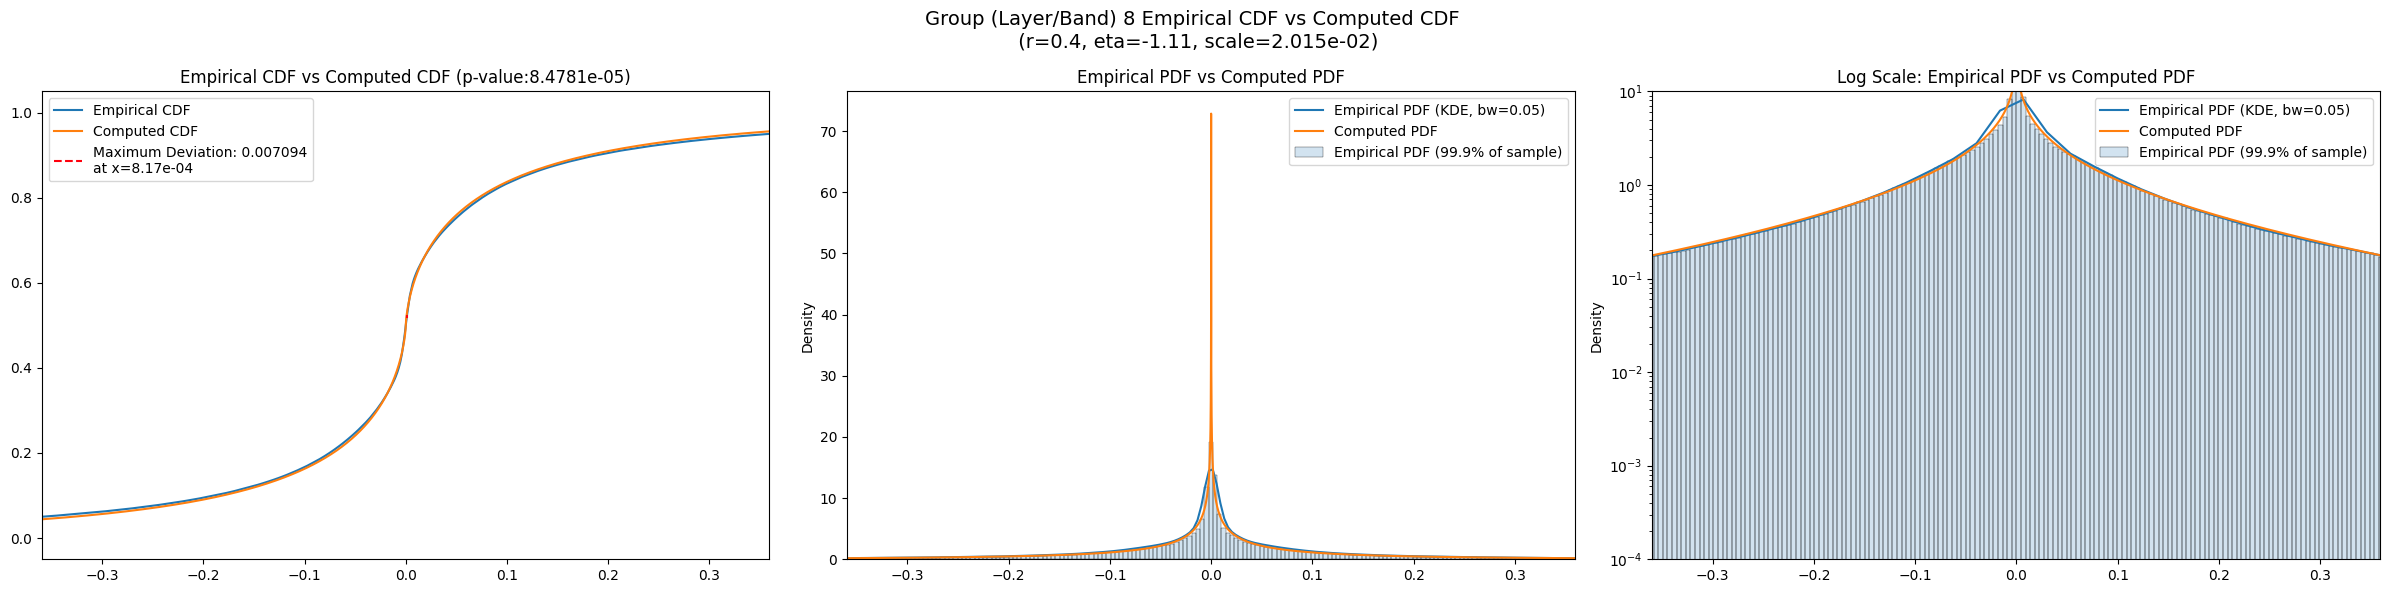

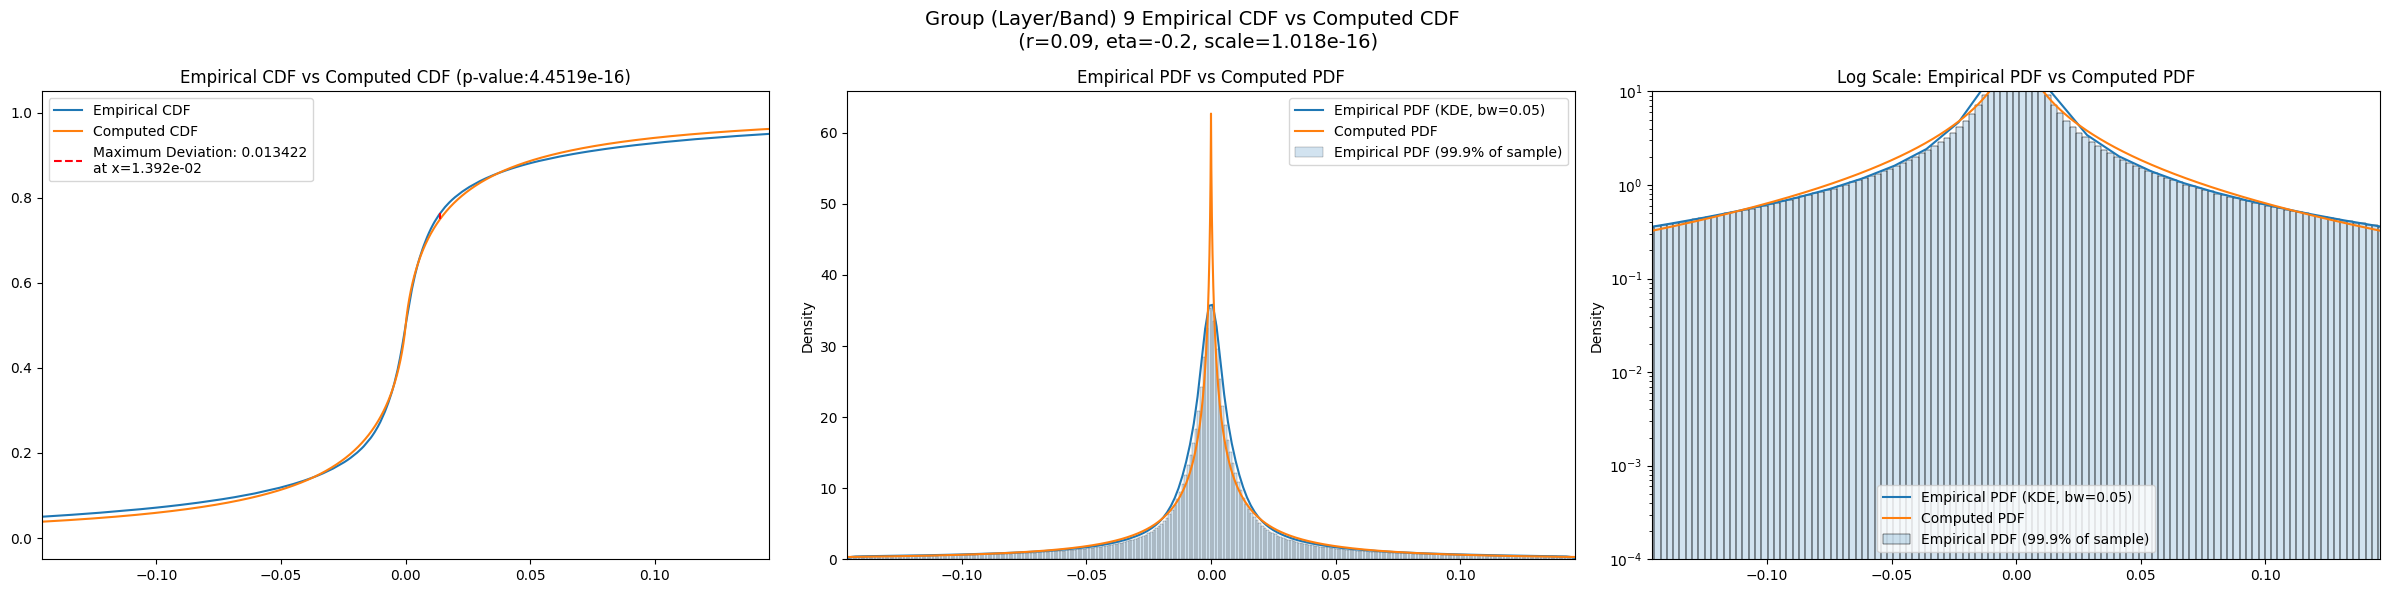

In [15]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [16]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [17]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        if len(group_data_map[group]) == 0:
            continue
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

obs_var    var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                 
2      1620.265600  1466.841600  1779.921800   0.232590   -0.116969   
3       363.693020   343.105830   384.706970   1.157368    0.861863   
4        67.676250    63.825962    71.663124   2.984240    2.370700   
5        11.568170    10.808815    12.363514   4.878991    3.933630   
6         1.933758     1.777439     2.103910   8.847498    6.484944   
7         0.346441     0.311654     0.386359  15.220030   10.219967   
8         0.080651     0.070203     0.095151  32.158560   15.513039   
9         0.018841     0.015640     0.024107  68.141560   25.292933   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        0.627984         1604.0             0.024899        9.9          0.1   
3        1.496571         6416.0             0.007488        5.8         -0.6   
4        3.709449        25664.0             0.004840        8.1         -1.0   
5        6.184278       102656.0             0.005401        1.4         -1.1   
6       14.128145       410624.0             0.019403        0.6         -1.1   
7       29.976894      1642496.0             0.022027       20.0         -1.3   
8      104.560486      6569984.0             0.008459        0.4         -1.1   
9      254.571980     26279936.0             0.014299        0.1         -0.3   

       ...  param_gaussian  kstest_stat_gaussian  kstest_pval_gaussian  \
layer  ...                                                               
2      ...       37.028000              0.028768          1.378690e-01   
3      ...       17.073200              0.022089          3.761590e-03   
4      ...        6.118480              0.043802          3.170470e-43   
5      ...        2.037900              0.062687          0.000000e+00   
6      ...        0.667626              0.075195          0.000000e+00   
7      ...        0.202323              0.091556          0.000000e+00   
8      ...        0.091523              0.081007          0.000000e+00   
9      ...        0.028561              0.088727          0.000000e+00   

       param_laplace  kstest_stat_laplace  kstest_pval_laplace    param_t  \
layer                                                                       
2          34.190100             0.032143         7.114540e-02  28.276500   
3          14.821800             0.011858         3.251470e-01  12.189900   
4           5.273880             0.018956         1.927810e-08   4.368760   
5           1.736480             0.037998        3.223720e-129   1.396290   
6           0.573775             0.049263         0.000000e+00   0.453814   
7           0.153022             0.078731         0.000000e+00   0.119097   
8           0.076106             0.059184         0.000000e+00   0.058485   
9           0.025592             0.064170         0.000000e+00   0.019585   

       kstest_stat_t  kstest_pval_t  kstest_pval_gengamma  
layer                                                      
2           0.034669   4.132080e-02          2.685516e-01  
3           0.018734   2.186430e-02          8.617912e-01  
4           0.024542   7.339300e-14          6.832046e-01  
5           0.042193  3.103380e-159          5.734941e-03  
6           0.051136   0.000000e+00         5.920352e-109  
7           0.080723   0.000000e+00          0.000000e+00  
8           0.060722   0.000000e+00         1.301508e-287  
9           0.060134   0.000000e+00          0.000000e+00  

[8 rows x 30 columns]

## Results

In [18]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [19]:
master_df.filter(regex="kstest_stat.*")

kstest_stat_initial  kstest_stat_cutoff_0.05  kstest_stat_best  \
layer                                                                   
2                 0.024899                 0.033804          0.024899   
3                 0.007488                 0.016929          0.007488   
4                 0.004840                 0.008471          0.004468   
5                 0.005401                 0.004237          0.005338   
6                 0.019403                 0.002119          0.017443   
7                 0.022027                 0.001060          0.022027   
8                 0.008459                 0.000530          0.007094   
9                 0.014299                 0.000265          0.013422   

       kstest_stat_gaussian  kstest_stat_laplace  kstest_stat_t  
layer                                                            
2                  0.028768             0.032143       0.034669  
3                  0.022089             0.011858       0.018734  
4                  0.043802             0.018956       0.024542  
5                  0.062687             0.037998       0.042193  
6                  0.075195             0.049263       0.051136  
7                  0.091556             0.078731       0.080723  
8                  0.081007             0.059184       0.060722  
9                  0.088727             0.064170       0.060134

In [20]:
master_df.filter(regex="best.*")

best_augmented_var  kstest_stat_best  best_r  best_eta    best_scale  \
layer                                                                         
2             1620.265600          0.024899    9.90      0.10  2.706929e+03   
3              363.693020          0.007488    5.80     -0.60  8.001653e+02   
4               64.321770          0.004468    8.00     -0.97  1.948243e+02   
5               11.319335          0.005338    1.30     -1.09  3.354919e+01   
6                1.933758          0.017443    1.00     -1.16  5.687522e+00   
7                0.346441          0.022027   20.00     -1.30  2.133540e+00   
8                0.064173          0.007094    0.40     -1.11  2.014673e-02   
9                0.018841          0.013422    0.09     -0.20  1.017966e-16   

       best_exclude_cutoff  
layer                       
2                      0.0  
3                      0.0  
4                     25.0  
5                     25.0  
6                      0.0  
7                      0.0  
8                    150.0  
9                      0.0